# FACE Recognition using Support Vector Machines (SVM)

This Jupyter Notebook will show you how to:  

* Create and evaluate SVM Model for FR
* Save your ML model
* Deploy it using Streamlit

**Relevant Links:** 

* If you want to know more about Face Recognition Applications https://face-rec.org/
* For image loading and manipulation see this link https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
* Parts of the materials presented here are adapted from  https://www.oreilly.com/library/view/python-data-science/9781491912126/
* Useufl tutorial https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html




### Load Data 

First, lets load the dataset from within Pyhon library using the `fetch` method. You can read more about the dataset at https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html. The code below might take some time on your machine: 

In [1]:
# load required libraries
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')# ignore warnings 
from sklearn.datasets import fetch_lfw_people # this is the dataset


In [2]:
# load data 
# get the data, with 60 images per person 
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


### Explore the Dataset

We can view some of the images in the dataset. Below, we view few images along with the names 

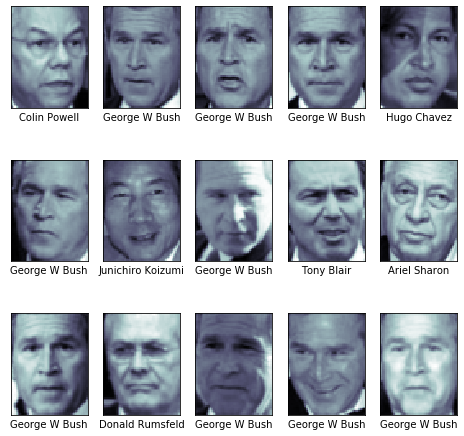

In [3]:
# create grid of 5 x 3 to sohw images 
fig, ax = plt.subplots(3, 5,figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

You can think of the above images as any other dataset we have been dealing with. Each image is 62 X 47 pixels. In computer vision, such image will be presented as  a one feature vector of size $62 X 47 = 2914$, you can think of this as a row of **2914** pixels for each images 

$[pixel_{00}, pixel_{01}, … , ... , pixel_{02914}]$<br>
$[pixel_{10}, pixel_{11}, … , ... , pixel_{12914}]$<br>
$[pixel_{20}, pixel_{21}, … , ... , pixel_{22914}]$



* Given this arrangement, we can simply proceed and feed all the pixels of each image into our machine learning algorithm (SVM). 

* However, in this task we will use something called Principle Component Analysis (**PCA**). This is an important method, that simply used to reduce the dimension of the data, without causing much information loss.  You can think of **PCA** as a method that projects a dataset of certain dimension into lower dimension (i.e. project 3D into 2D). 

* Notice that also for the above data, the label or $y$ is actually the name of the person in the image.



### Pre-process and Model's Creation 


**Pipeline**: The code below applies PCA to reduce the dimension of our data from almost 3000 into only 150, meaningful dimension and feed it into our Support Vector Machine. These two steps can be combined together into a single pipleline using the python `Pipeline`. Notice, here we define our pipeline using the mehtod `make_pipeline` as outlined below:  



In [4]:

# create dimenssion reduction 
pca = PCA(n_components=150, whiten=True, random_state=42)
# create your SVM model with RBF kernel 
svc = SVC(kernel='rbf', class_weight='balanced')
# your pipline 
model = make_pipeline(pca, svc)

### Train / Test Split

As always, it is important to keep part of our dataset for testing and validation of our model’s performance: 

In [5]:
from sklearn.model_selection import train_test_split
# random_state is for results reproduction 
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target,test_size=0.2,
                                                random_state=42)

In [6]:
# check the shape of the data
print(f'The size of the Training set is {X_train.shape[0]}')
print(f'The size of the Training set is {X_test.shape[0]}')
# notice the number of column in the dataset
print(f'The number of columns in the training and testing set is {X_train.shape[1]}')


The size of the Training set is 1078
The size of the Training set is 270
The number of columns in the training and testing set is 2914


In [7]:
# You should know the data types of X_train / y_train (numpy array)
print(f'Type of X_train {type(X_train)}')
print(f'Type of y_train {type(y_train)}')

Type of X_train <class 'numpy.ndarray'>
Type of y_train <class 'numpy.ndarray'>


### Hyperparameter Tuning

SVM has several parameters, `C` and `gamma` are two important parameters for the performance of the model. You can try to set these manually, but this can be time consuming. However, here, we will use **grid search** to get the best set of parameters.

In [8]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

* Now, fit the data and search for the best parameters 

In [9]:
warnings.filterwarnings('ignore')# ignore warnings 

grid.fit(X_train, y_train)
best_params = grid.best_params_


In [10]:
# check best parameters
print(best_params)

{'svc__C': 10, 'svc__gamma': 0.005}


* Now, lets use our model to predict the labels (names) of the test images 


### Best Model Fit

In [11]:
# best model we have 
model = grid.best_estimator_
y_predicted = model.predict(X_test)


* Lets check some of our predictions. We will flag wrong predictions with **red** labels along the images 

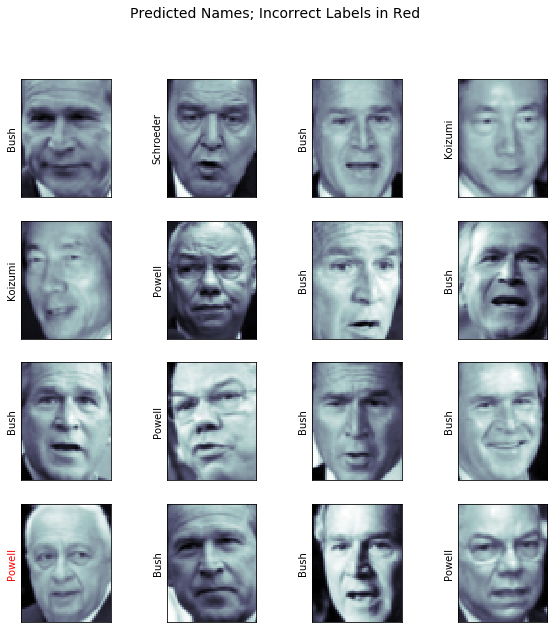

In [12]:
fig, ax = plt.subplots(4, 4,figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_predicted[i]].split()[-1],
                   color='black' if y_predicted[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);



* Lest now look at evaluation metrics to assess the quality of our model: 

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.58      0.70        12
     Colin Powell       0.84      0.84      0.84        51
  Donald Rumsfeld       0.91      0.80      0.85        25
    George W Bush       0.79      0.95      0.86        98
Gerhard Schroeder       1.00      0.76      0.86        21
      Hugo Chavez       1.00      0.67      0.80        15
Junichiro Koizumi       1.00      0.70      0.82        10
       Tony Blair       0.89      0.89      0.89        38

         accuracy                           0.85       270
        macro avg       0.91      0.77      0.83       270
     weighted avg       0.86      0.85      0.85       270



* Also, it is always useful to view  the confusion matrix (lecture notes):

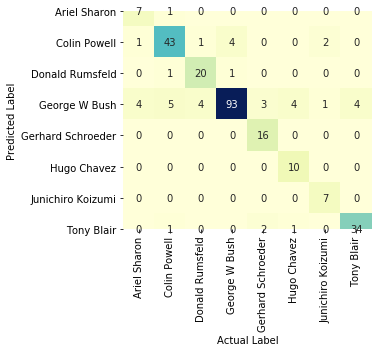

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# compare the actual label against the predicted label
mat = confusion_matrix(y_test, y_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap="YlGnBu",
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label');

## Save the Model 

We can now save the model for later use: 

In [15]:
import pickle
# Save to file in the current working directory
pkl_filename = "svm_model.pkl"
# save your model that was created above (lg_model)
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)


* And, you can always load it and re-use it, without the need to retrain it again, as follows: 

In [16]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
# Lets test the mode loaded from a file and check results
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
y_hat = pickle_model.predict(X_test)

Test score: 85.19 %


In [17]:
# you can save your test set as a data frame as below
df = pd.DataFrame(X_test)
# add the label 
df['Label']=y_test
# save to csv
df.to_csv('Xy_test.csv', index=False)


* perform some predictions using the loaded model


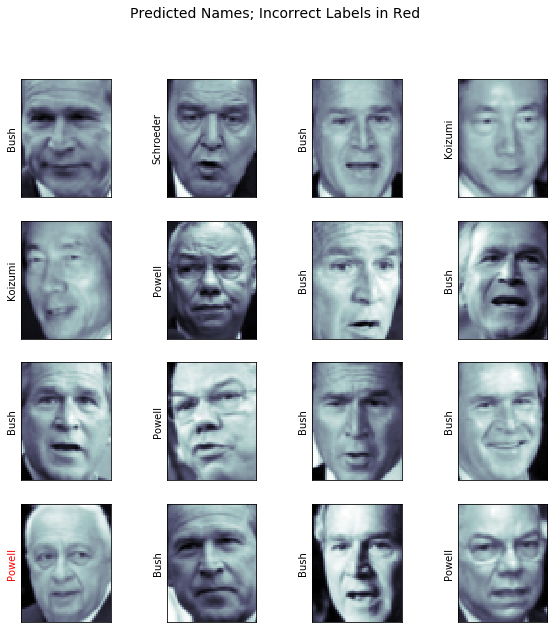

In [18]:
y_predictedp = pickle_model.predict(X_test)

fig, ax = plt.subplots(4, 4,figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_predicted[i]].split()[-1],
                   color='black' if y_predictedp[i] == y_test[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);


## Streamlit App

Details presented in the demo can also be found at `streamlitApp.py` on the github repo with more details